## Federated Learning to Predict Hospital Admissions
### Section 4: Model Comparison
The fourth and final notebook of the series compares results from the model with and without federated learning.

In [37]:
import pandas as pd
import pickle
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import re
from collections import OrderedDict

import sys
sys.setrecursionlimit(20000)

In [38]:
# Load test data 
basePath = "/Users/austin.bellibm.com/Documents/FederatedLearning/Part 2 - Applied Healthcare/Federated Learning - Hospital Readm/"
provider_test = pd.read_csv(f'{basePath}Party3/Provider_test.csv', dtype='category')
provider_train = pd.read_csv(f'{basePath}Party3/Provider_train.csv', dtype='category')

# Load models
max_depth = 6
fed_models = []
base_models = []

for i in range(1, max_depth+1):
    fed_models.append(pickle.load(open(f"{basePath}Models/Federated DT_{i}.pkl","rb")))
    base_models.append(open(f"{basePath}Models/Base DT_{i}.txt", "rb").readlines())

In [39]:
fed_models[1]

{'leaf': False,
 'counts': None,
 'outcome': None,
 'split': 4,
 '1': {'leaf': False,
  'counts': None,
  'outcome': None,
  'split': 12,
  '(-inf, 0.528]': {'leaf': True,
   'counts': [2264, 3335, 4470],
   'outcome': 'NO',
   'split': None},
  '(0.528, 1.056]': {'leaf': True,
   'counts': [991, 1256, 817],
   'outcome': '>30',
   'split': None},
  '(1.056, 1.583]': {'leaf': True,
   'counts': [771, 674, 263],
   'outcome': '<30',
   'split': None},
  '(1.583, 2.111]': {'leaf': True,
   'counts': [350, 240, 37],
   'outcome': '<30',
   'split': None},
  '(2.111, inf]': {'leaf': True,
   'counts': [59, 21, 1],
   'outcome': '<30',
   'split': None}},
 '10': {'leaf': False,
  'counts': None,
  'outcome': None,
  'split': 0,
  'AfricanAmerican': {'leaf': True,
   'counts': [0, 0, 0],
   'outcome': '<30',
   'split': None},
  'Asian': {'leaf': True,
   'counts': [0, 0, 0],
   'outcome': '<30',
   'split': None},
  'Caucasian': {'leaf': True,
   'counts': [0, 0, 0],
   'outcome': '<30',
  

In [40]:
base_models[1]

[b'\n',
 b'discharge_disposition_id 1\n',
 b'|   number_inpatient (-inf, 0.528]: NO (822/1196) \n',
 b'|   number_inpatient (0.528, 1.056]: >30 (214/364) \n',
 b'|   number_inpatient (1.056, 1.583]: <30 (124/170) \n',
 b'|   number_inpatient (1.583, 2.111]: <30 (38/37) \n',
 b'|   number_inpatient (2.111, inf]: <30 (1/1) \n',
 b'discharge_disposition_id 10: NO (1) \n',
 b'discharge_disposition_id 11: NO (53) \n',
 b'discharge_disposition_id 13\n',
 b'|   age [10-20): NO (10/3) \n',
 b'|   age [20-30): NO (10/3) \n',
 b'|   age [30-40): NO (10/3) \n',
 b'|   age [40-50): >30 (1) \n',
 b'|   age [50-60): NO (10/3) \n',
 b'|   age [60-70): NO (1) \n',
 b'|   age [70-80): NO (2/1) \n',
 b'|   age [80-90): NO (3/1) \n',
 b'|   age [90-100): NO (4) \n',
 b'discharge_disposition_id 14\n',
 b'|   time_in_hospital (-inf, 1.096]: >30 (1) \n',
 b'|   time_in_hospital (1.096, 1.499]: NO (6) \n',
 b'|   time_in_hospital (1.499, 1.902]: NO (5) \n',
 b'|   time_in_hospital (1.902, 2.305]: <30 (2/3) \

In [41]:
class node(object):
    """
    Node object that stores all relevant information for a branch in decision tree
    """
    def __init__(self, col, parent):
        self.col = col
        self.parent = parent
        self.split_children = OrderedDict()
        
    def add_child(self, current_split, child_node):
        self.split_children[current_split].append(child_node)
        
    def add_split(self, current_split):
        self.split_children[current_split] = []
    

# convert to same format as Federated DT
def createTree(model):

    "Initiates the tree and runs the recursion"
    
    # Create root node
    i = 1 # skip first item
    max_depth = 0
    primary_depth = 0
      
    primary_node = str(model[i]).replace("b'", "")[:-3] #removes \n too

    primary_depth = primary_node.count('|')

    # extract relevant information about the node
    col, primary_split, outcome = extract_node_info(primary_node)
    primary_node = node(col, None)
    primary_node.add_split(primary_split)


    # recursively add to the node
    recurse(model, primary_node, primary_depth, i+1) 

    return primary_node

def recurse(model, primary_node, primary_depth, i):

    "Recursive function to traverse and generate tree"
    
    # termination criteria
    if i >= len(model):
        return primary_node
    
    curr_node = str(model[i]).replace("b'", "")[:-3] #removes \n too
    curr_depth = curr_node.count('|')

    # extract relevant information about the node
    col, split, outcome = extract_node_info(curr_node)

    # next level of tree
    if curr_depth > primary_depth:
        curr_node = node(col, primary_node)
        
        # is the current node an outcome node
        if outcome != None:
            # if yes then add as child but do not change primary node
            # child added to most recent split of primary node
            # if child already exists then add split 
            # for both, add outcome as child of current node
            
            if len(list(primary_node.split_children.values())[-1]) == 0:
                primary_node.add_child(list(primary_node.split_children.keys())[-1], curr_node)
                curr_node.add_split(split)
                curr_node.add_child(split,outcome)
            else:
                prev_node = list(primary_node.split_children.values())[-1][0]
                prev_node.add_split(split)
                prev_node.add_child(split,outcome) 
                
            
            tree = recurse(model, primary_node, primary_depth, i+1)
            
        else:
            # if not outcome node then add as child, change the primary node and recurse
            if len(list(primary_node.split_children.values())[-1]) == 0:
                primary_node.add_child(list(primary_node.split_children.keys())[-1], curr_node)
                
            else: # if child already added then add split
                curr_node = list(primary_node.split_children.values())[-1][0] #extract the already added child
                
                
            curr_node.add_split(split)
            tree = recurse(model, curr_node, curr_depth, i+1)
        
    # if current depth is equal to the primary node's depth then it is a new split for the primary node
    # add the split - no change in primary node
    elif curr_depth == primary_depth:
        primary_node.add_split(split)
        if outcome != None:
            primary_node.add_child(split,outcome)
        
        tree = recurse(model, primary_node, primary_depth, i+1)
            
    # if current depth is less then we are moving back up the tree and this is a new split of the parent node
    elif curr_depth < primary_depth:
        
        # extract the correct parent node
        diff = primary_depth - curr_depth
        parent_node = primary_node
        for _ in range(diff):
            parent_node = parent_node.parent
        
        parent_node.add_split(split)
        
        if outcome != None:
            parent_node.add_child(split,outcome)
            
        tree = recurse(model, parent_node, curr_depth, i+1)
            

                
def extract_node_info(node):
    """
    Extract feature name, feature value to split on, and possible outcome
    """             
    col = re.search("([A-Za-z_1-9]+.*?) ", node, re.IGNORECASE).group(1)
    
    # if colon then extract outcome
    if re.search(":", node):
        split = node.split(": ")
        
        value_split = split[0]
        value = re.search(col + " (.*?)$", value_split).group(1)
        
        outcome_split = split[1]
        outcome = re.search("(.*?) ", outcome_split).group(1)
        return col, value, outcome
    else:
        outcome = None
    
    value = re.search(col + " (.*?)$", node).group(1)

    return col, value, outcome

In [42]:
# Now that we have the tree - we can convert to the same json format as the federated learning model
def tree2json(node, key = None):
    if isinstance(list(node.split_children.values())[0], str): # outcome node, return leaf
        # if the node has a child that is a string then it is an outcome

        # base leaf format
        leaf = {
            "leaf":False,
            "outcome": None,
            "col": node.col,
            "split": provider_train.columns.get_loc(node.col)
        }
        
        # loop through all of the splits/outcomes and attach to base leaf
        # return once completed
        for key, value in node.split_children.items():
            try:
                value[0][0]
            except:
                print(value, key)
            
            
            leaf[key] = {
                "leaf":True,
                "outcome":value[0],
                "col": None,
                'split': None
            }
        
        
        return leaf
    
    # if not outcome, recursively include splits from child
    root = {
        "leaf":False,
        "outcome":None,
        "col": node.col,
        "split": provider_train.columns.get_loc(node.col)
    }
    
    # I made it so everything only has one child now, so technically i dont have to loop and can just extract
    for key, children in node.split_children.items(): 
        for child in children:
            if not isinstance(child, str):
                root[key] = tree2json(child, key)
                
            else: # return leaf
                root[key] = {
                        "leaf":True,
                        "outcome":children[0],
                        "col": None,
                        'split': None
                    }
                
    return root


In [43]:
# run recursion algorithm to create nested json trees for the base models
import json
base_models_json = []
for model in base_models:
    tree =createTree(model)
    base_models_json.append(tree2json(tree))
    
js = json.dumps(base_models_json[1], indent = 2)
print(js)

{
  "leaf": false,
  "outcome": null,
  "col": "discharge_disposition_id",
  "split": 4,
  "1": {
    "leaf": false,
    "outcome": null,
    "col": "number_inpatient",
    "split": 12,
    "(-inf, 0.528]": {
      "leaf": true,
      "outcome": "NO",
      "col": null,
      "split": null
    },
    "(0.528, 1.056]": {
      "leaf": true,
      "outcome": ">30",
      "col": null,
      "split": null
    },
    "(1.056, 1.583]": {
      "leaf": true,
      "outcome": "<30",
      "col": null,
      "split": null
    },
    "(1.583, 2.111]": {
      "leaf": true,
      "outcome": "<30",
      "col": null,
      "split": null
    },
    "(2.111, inf]": {
      "leaf": true,
      "outcome": "<30",
      "col": null,
      "split": null
    }
  },
  "10": {
    "leaf": true,
    "outcome": "NO",
    "col": null,
    "split": null
  },
  "11": {
    "leaf": true,
    "outcome": "NO",
    "col": null,
    "split": null
  },
  "13": {
    "leaf": false,
    "outcome": null,
    "col": "age"

In [44]:
def predict(x_test, model, training_df, node=None):
        """
        Perform prediction for a data instance.
        """
        predicts = list()

        if node is None:
            if len(model) != 0:
                node = model
            else:
                raise ValueError('Decision tree model is empty.')

        if node['leaf']:
            predicts.append(node['outcome'])
            return predicts

        index = node['split']
        val = x_test.iloc[0][index]
        
        # if value is unseen category then select value from training that is most likeley to occur
        try:
            tmp = node[val]
        except:
            val = training_df.iloc[:,index].value_counts().index[0]
        
        if node[val] is None:
            
            predicts.append(node['outcome'])
            return predicts

        x_predict = predict(x_test, model, training_df, node[val])
        return predicts + x_predict

In [45]:
def evaluate(X_test, y_test, X_train, model):
    correct = 0
    predicts = []

    for i in range(X_test.shape[0]):
        predicts += predict(X_test.iloc[[i]], model, X_train)
        if predicts[i] == y_test[i]:
            correct = correct + 1

    print("Accuracy is: " + str(correct / len(X_test)))
    
    return predicts

X_test = provider_test.drop(columns=['class'])
y_test = provider_test['class']

fed_preds = []
base_preds = []

for i in range(1,max_depth):
    print("Federated Learning Model - Depth: " + str(i+1))
    fed_preds.append(evaluate(X_test, y_test, provider_train, fed_models[i]))

    print("Baseline Model - Depth: " + str(i+1))
    base_preds.append(evaluate(X_test, y_test, provider_train, base_models_json[i]))
    
    print("\n")

Federated Learning Model - Depth: 2
Accuracy is: 0.46242432219005003
Baseline Model - Depth: 2
Accuracy is: 0.45400105290866016


Federated Learning Model - Depth: 3
Accuracy is: 0.4541984732824427
Baseline Model - Depth: 3
Accuracy is: 0.47367728349565674


Federated Learning Model - Depth: 4
Accuracy is: 0.4822979731508292
Baseline Model - Depth: 4
Accuracy is: 0.4232034745985786


Federated Learning Model - Depth: 5
Accuracy is: 0.4473545669913135
Baseline Model - Depth: 5
Accuracy is: 0.41300342195314554


Federated Learning Model - Depth: 6
Accuracy is: 0.41728086338510134
Baseline Model - Depth: 6
Accuracy is: 0.39720979205053963




Extract results and visualize

In [46]:
# print classification reports and save precision, recall, and f1 scores
fed_scores = {'accuracy':[],
              'f1':[],
              'precision':[],
              'recall':[]}
base_scores = {'accuracy':[],
               'f1':[],
               'precision':[],
               'recall':[]}

for i in range(max_depth-1):
    print("Classification Report: Federated Learning Decision Tree - Depth: " + str(i+2))
    print(classification_report(y_test, fed_preds[i]))
    fed_scores['accuracy'].append(accuracy_score(y_test, fed_preds[i]))
    fed_scores['f1'].append(f1_score(y_test, fed_preds[i], average = 'weighted'))
    fed_scores['precision'].append(precision_score(y_test, fed_preds[i], average = 'weighted'))
    fed_scores['recall'].append(recall_score(y_test, fed_preds[i], average = 'weighted'))
    
    
    print("Classification Report: Baseline Decision Tree - Depth: " + str(i+2))
    print(classification_report(y_test, base_preds[i]))
    base_scores['accuracy'].append(accuracy_score(y_test, base_preds[i]))
    base_scores['f1'].append(f1_score(y_test, base_preds[i], average = 'weighted'))
    base_scores['precision'].append(precision_score(y_test, base_preds[i], average = 'weighted'))
    base_scores['recall'].append(recall_score(y_test, base_preds[i], average = 'weighted'))

Classification Report: Federated Learning Decision Tree - Depth: 2
              precision    recall  f1-score   support

         <30       0.19      0.38      0.25      1745
         >30       0.41      0.31      0.35      5422
          NO       0.61      0.58      0.60      8029

   micro avg       0.46      0.46      0.46     15196
   macro avg       0.40      0.42      0.40     15196
weighted avg       0.49      0.46      0.47     15196

Classification Report: Baseline Decision Tree - Depth: 2
              precision    recall  f1-score   support

         <30       0.17      0.41      0.24      1745
         >30       0.44      0.28      0.34      5422
          NO       0.62      0.58      0.60      8029

   micro avg       0.45      0.45      0.45     15196
   macro avg       0.41      0.42      0.39     15196
weighted avg       0.50      0.45      0.47     15196

Classification Report: Federated Learning Decision Tree - Depth: 3
              precision    recall  f1-score   s

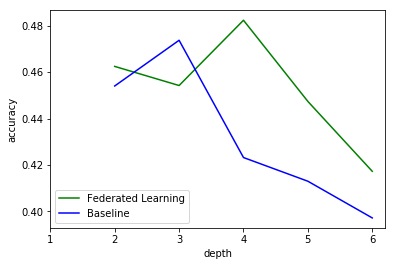

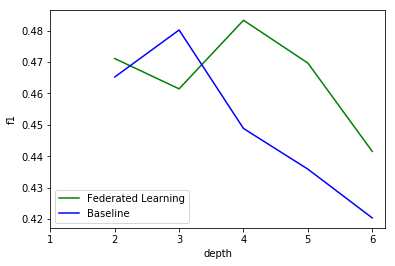

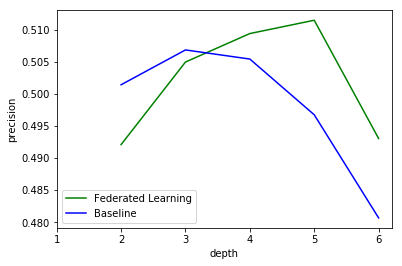

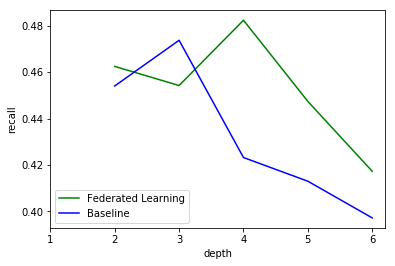

In [50]:
import matplotlib.pyplot as plt

def plot_scores(score, title = None):
    plt.plot(list(range(2, max_depth+1)),fed_scores[score], color = 'g', label = 'Federated Learning')
    plt.plot(list(range(2, max_depth+1)), base_scores[score], color = 'b', label = 'Baseline')
    plt.xlabel("depth")
    plt.ylabel(score)
    plt.xticks(range(1,7))
    if title is not None:
        plt.title(title)
        
    plt.legend(loc = 'lower left')
    plt.show()
    
for key in fed_scores.keys():
    plot_scores(key)

{'f1': [0.59, -1.87, 3.45, 3.38, 2.12], 'precision': [-0.93, -0.19, 0.4, 1.47, 1.24], 'recall': [0.84, -1.95, 5.91, 3.44, 2.01]}


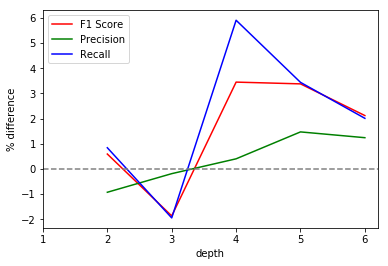

In [69]:
# measure percent difference between Federated Learning and Baseline Models at each depth 
def perc_diff(fed_scores, base_scores, metrics = []):
    perc_diff_dict = {}
    for metric in metrics:
        perc_diff_dict[metric] = []
        
        for i in range(len(fed_scores[metric])):
            fed_score = fed_scores[metric][i]
            base_score = base_scores[metric][i]
            
            diff = round((fed_score-base_score)*100,2)
            perc_diff_dict[metric].append(diff)
            
    return perc_diff_dict

perc_diff_dict = perc_diff(fed_scores, base_scores, metrics = ['f1', 'precision', 'recall'])
print(perc_diff_dict)

# graph the percent change at each depth 
plt.plot(list(range(2, max_depth+1)),perc_diff_dict['f1'], color = 'r', label = 'F1 Score')
plt.plot(list(range(2, max_depth+1)), perc_diff_dict['precision'], color = 'g', label = 'Precision')
plt.plot(list(range(2, max_depth+1)), perc_diff_dict['recall'], color = 'b', label = 'Recall')
plt.xlabel("depth")
plt.ylabel("% difference")
plt.xticks(range(1,7))
plt.axhline(y=0, color='grey', linestyle='--')

plt.legend(loc = 'upper left')
plt.show()